In [1]:
import sympy as sym
import sympy.physics.mechanics as me

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

In [2]:
# want to create a model with some fixed parameters

# create the variables
p = dof2.FwtParameters.Default2DoF() # parameter container

mass_ratio = 4                    # mass ratio between wing and FWT
p.m_w = dof2.FwtVariable(4,'m_w')   # mass of inner wing
wing_freq = 2                       # freq of inner wing

# set values for independent symbols
p.s.value = 1
p.c.value = 0.15
p.g.value = 9.81
p.rho.value = 1.225
p.a_t.value = 2 * np.pi
p.alpha_r.value = np.deg2rad(10)
p.Lambda.value = np.deg2rad(-10)

# set expression for dependent symbols
p.k = (sym.Integer(wing_freq)*2*sym.pi)**2*(p.m_w+p.m_w/sym.Float(mass_ratio))
p.m = p.m_w/sym.Integer(mass_ratio)
p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1
p.l = p.s*sym.Rational(2,4)

# potential Energy
half = sym.Rational(1,2)
U = p.m*p.g*(-p.l*sym.cos(p.q[0])) + half*p.k*(p.q[1])**2

# Create Point masses

# Transform for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(-sym.pi*sym.Rational(1,2)+p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([-sym.pi*sym.Rational(1,2)+p.q[0],0,0])


mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)


M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)

m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)


# Aero Forces
AeroForces = ams.SimpleAeroModel(p,fwt_frame,at_mode=1)
me.mechanics_printing()


sm = dof2.SymbolicModel(U,[mw,m],p,ExtForces = AeroForces)

In [3]:
sm.EoM.jacobian(p.qdd)

⎡        2                   ⎤
⎢   m_w⋅s       m_w⋅s⋅sin(q₀)⎥
⎢   ──────      ─────────────⎥
⎢     12              8      ⎥
⎢                            ⎥
⎢m_w⋅s⋅sin(q₀)      5⋅m_w    ⎥
⎢─────────────      ─────    ⎥
⎣      8              4      ⎦

Text(0.5, 0, 't [s]')

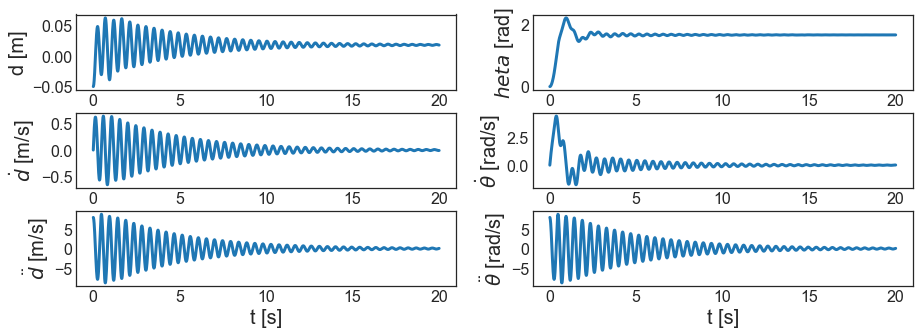

In [61]:
tmax, dt = 20, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 18

def arfunc(t,x):
    return np.deg2rad(10)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)

p.V.value = Vfunc
p.alpha_r.value = arfunc

y0 = [0,0,-0.05,0]
#y0 = [1.5,0,0.02,0]
yData = solve_ivp(lambda t,y:sm.deriv(t,y,p),(0,tmax),y0,max_step=dt)

# interpolate data onto a uniform time grid
t = np.arange(0, tmax+dt, 0.01)
yi = np.zeros((len(t),len(y0)+2)).T
for i in range(0,len(y0)):
    yi[i] = np.interp(t,yData.t,yData.y[i])
for i in range(0,2):
    yd = sm.deriv(0,yi[:4,:],p)
    yi[i+4,:] = yd[1]
    yi[i+4,:] = yd[3]

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(3,2,figsize=(15,5))

# d plot
axes[0][0].plot(t,yi[2])
axes[0][0].set_ylabel('d [m]')
axes[0][0].set_xlabel('t [s]')

# theta plot
axes[0][1].plot(t,yi[0])
axes[0][1].set_ylabel('$\theta$ [rad]')
axes[0][1].set_xlabel('t [s]')


# ddot plot
axes[1][0].plot(t,yi[3])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[1])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# ddot plot
axes[2][0].plot(t,yi[4])
axes[2][0].set_ylabel('$\ddot{d}$ [m/s]')
axes[2][0].set_xlabel('t [s]')

# thetadot plot
axes[2][1].plot(t,yi[5])
axes[2][1].set_ylabel(r'$\ddot{\theta}$ [rad/s]')
axes[2][1].set_xlabel('t [s]')

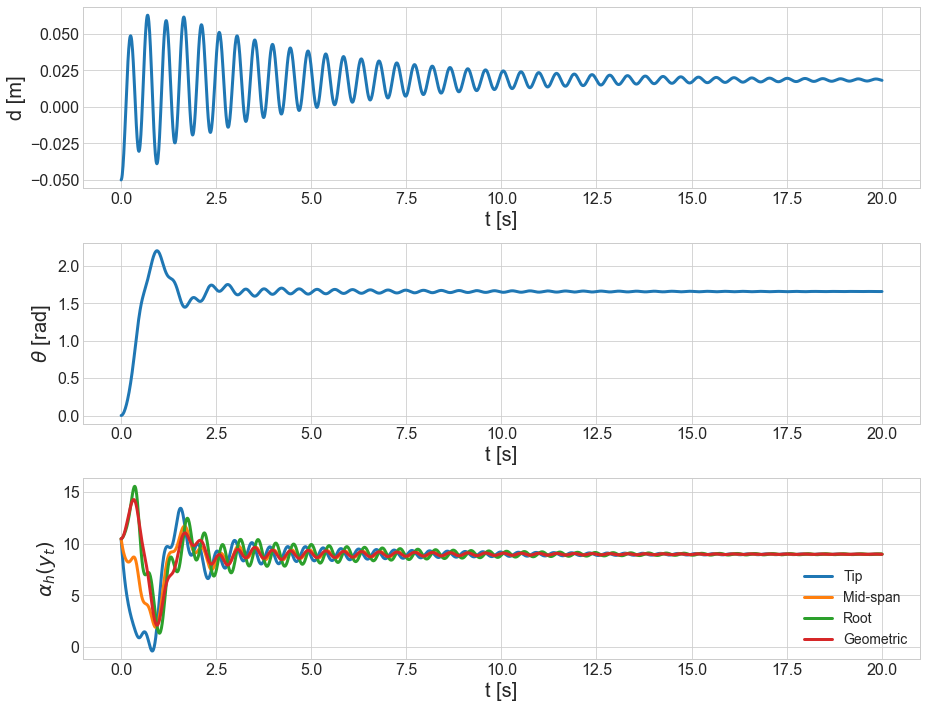

In [62]:
plt.style.use('seaborn-whitegrid')
plt.style.use(r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Projects\FWTD modelling\Styles\presentation.mplstyle')
   
fig, axes = plt.subplots(3,1,figsize=(15,12))
#fig.tight_layout()
# d plot
axes[0].plot(t,yi[2])
axes[0].set_ylabel('d [m]')
axes[0].set_xlabel('t [s]')

# theta plot
axes[1].plot(t,yi[0])
axes[1].set_ylabel(r'$\theta$ [rad]')
axes[1].set_xlabel('t [s]')

# Local Angle of Attack plots
alphas = AeroForces.GetAlpha(p,yi[:4,:],1,t)
alphas2 = AeroForces.GetAlpha(p,yi[:4,:],0.5,t)



l1, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi[:4,:],1,t)))
l2, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi[:4,:],0.5,t)))
l3, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi[:4,:],0,t)))

#zero velocities
yi_v0 = yi[:4,:].copy()
yi_v0[[1,3],:] = 0
l4, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi_v0,0,t)))

l1.set_label('Tip')
l2.set_label('Mid-span')
l3.set_label('Root')
l4.set_label('Geometric')
axes[2].legend()
axes[2].set_ylabel(r'$\alpha_h(y_t)$')
axes[2].set_xlabel('t [s]')
#axes[3][0].set_ylim(0.5,1.5)
PhotoDir = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Projects\FWTD modelling\Videos & Photos'+'\\'
plt.savefig(PhotoDir + r'ModelStates.png',transparent=True,bbox_inches='tight')

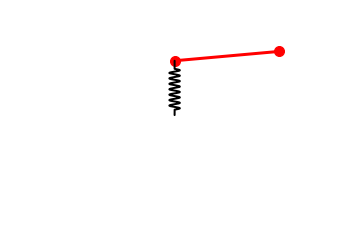

In [63]:
import matplotlib.animation as animation
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Programs\ffmpeg-20200211-f15007a\bin\ffmpeg.exe'

spring_size = 0.5
fig = plt.figure()
ax = plt.axes(xlim=(-1.2,1.2),ylim=(-1.2,1.2))
ax.axis('equal')
ax.set()
fwt, = ax.plot([],[],'ro-')
spring = cpo.Spring.FromLengthAndAngle(np.pi/2,p.s.value,ax = ax)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    spring.ReplotSpring((0,0),np.pi,1+y0[2])
    fwt.set_data([0,p.s.value],[1,1])
    return spring.springObj,fwt
                    
def animate(i):
    theta = yi[0,i]
    d = yi[2,i]
    spring.ReplotSpring((0,0),np.pi,d+spring_size)
    fwt.set_data([0,p.s.value*np.sin(theta)],[d+spring_size,-p.s.value*np.cos(theta)+d+spring_size])
    return spring.springObj,

plt.axis('off')    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=20, blit=True)
#anim.save(f'basic_animation_{test_case+1}.mp4', fps=30)
HTML(anim.to_html5_video())